Reference: https://github.com/chengxi600/RLStuff/blob/master/Policy%20Gradients/REINFORCE-Baseline.ipynb

In [35]:
from torch.utils.tensorboard import SummaryWriter

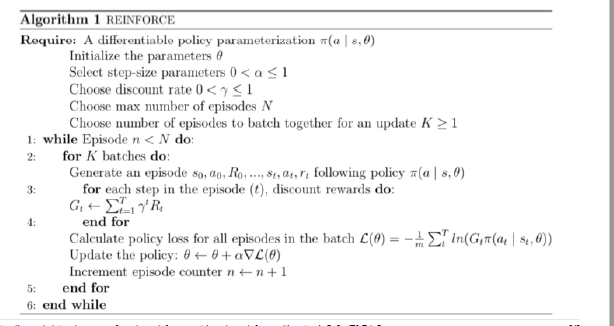

In [1]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd

In [2]:


#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state



class Machine_env():
    '''
    Description:
    Code creates an environment for the policy to interact with the simulated machine.

    States:
    The simulated machine has 10 states
    [0,1,2,3] are working states that degrades as the state number increases.
    [4,5,6,7] are maintenance states that are transited from [0,1,2,3] respectively if the action deems it need transition
    [8,9] are failure state, where 8 is sudden failure state that can occur from [0,1,2,3] while 9 is a degraded failure from 3

    Actions:
    Type: Discrete(2)
    Num
    0: No maintenance
    1: Maintenance

    Rewards:
    reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

    Observations:
    Produced using MachineSensor class that uses gmm from pickle file

    Episode:
    Since it is continous Markov model, we shall set 1 episode is 20 steps


    Pseudo code

    initialise class
    Loop 20 times: #1 episode
        sensor()
        action()
        step()

    final otp: Class that contains rewards,actions, observations --> will be used to improve policy (ie. optimise theta)
        
''' 

    def __init__(self,machine):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}
        self.observation_space = 4
        self.transition  = [a0_tm,a1_tm]
        self.simulator = machine #simulator to generate sensor readings
        self.done = False
        self.steps = 0
    
    def sensor(self): # generate observation at state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        self.simulator.curr_state = self.state #update GMM state
        
        while(self.state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.transition[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based on prob
            self.state = nxt_state #update state
            self.simulator.curr_state = self.state #update GMM state
            reward+=self.reward_func[nxt_state]
            
        
        self.steps += 1
        
#         if(self.steps == 50):#condition for end of episode
#             self.done = True
        if self.state in [8,9] or self.steps > 100:
            self.done = True

        return reward
    
    def reset(self):
        self.state = 0
        self.simulator.curr_state = self.state
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        
class policy_estimator(): #neural network
    def __init__(self, env):
        self.n_inputs = env.observation_space
        self.n_outputs = len(env.action_space)
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 128), 
            nn.ReLU(), 
            nn.Linear(128, 256),
            nn.ReLU(), 
            nn.Linear(256, self.n_outputs),
        nn.Softmax(dim=-1))
        
    
    def predict(self,observation):#prediction is raw value
        return self.network(torch.FloatTensor(observation))

In [6]:
def entropy(distribution,entropy_coeff):
    entropy = 0
    x = distribution.detach().numpy()
    for row in x:
        entropy += -np.sum(row + np.log(row))

    ave_entropy = entropy/len(x)
    return ave_entropy*entropy_coeff

In [7]:
def discount_rewards(rewards, gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

def reinforce(machine,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
     # Set up lists to hold results
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_obs=[]
    batch_actions = []
    ave_reward_store = []
    batch_counter = 1
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.network.parameters(),lr=lr)
    
    action_space = machine.action_space
    ep=0
    while ep < num_episodes:
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while machine.done == False:
            obs = machine.sensor().tolist() #get observation
            
            action_probs = policy_estimator.predict(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            #print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
            
            if machine.done == True:
                batch_rewards.extend(normalized_discount_reward(rewards, gamma))
                batch_obs.extend(observation)
                batch_actions.extend(actions)
                batch_counter+=1
                total_rewards.append(sum(rewards))
                
                if batch_counter == batch_size:
                    discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
                    #update policy
                    obs_tensor = torch.FloatTensor(batch_obs)
                    action_tensor = torch.LongTensor(batch_actions)
                    reward_tensor = torch.from_numpy(np.array(batch_rewards).copy()) #resolve stride problem

                    #Calculate loss Ver 3
                    logprob = torch.log(policy_estimator.predict(obs_tensor))
                    #print(logprob)
                    #print(logprob[np.arange(len(action_tensor)), action_tensor])
                    selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
                    #print(selected_logprobs)
                    
                    loss = -selected_logprobs.mean()

                    
                    optimizer.zero_grad()
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_obs = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-10:])
                ave_reward_store.append(avg_rewards)
                # Print running average
                print("\rEp: {} Average of last {}: {:.2f}".format(ep+1,batch_size,avg_rewards), end="")
                ep+=1

            #         #Tensorboard params
            #         writer.add_scalar("Loss", loss, ep)
            #         writer.add_scalar('Rewards',sum(rewards),ep)
            #         for name, weight in policy_estimator.network.named_parameters():
            #             try:
            #                 writer.add_histogram(name,weight, ep)
            #             except:
            #                 continue
            #             if weight.grad != None:
            #                 writer.add_histogram(f"{name}.grad",weight.grad, ep)

            #     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
            #     writer.flush()
            #     writer.close()
    
    return (ave_reward_store,total_rewards,state_seq)

# Normal REINFORCE

Ep: 1000 Average of last 10: 22720.00

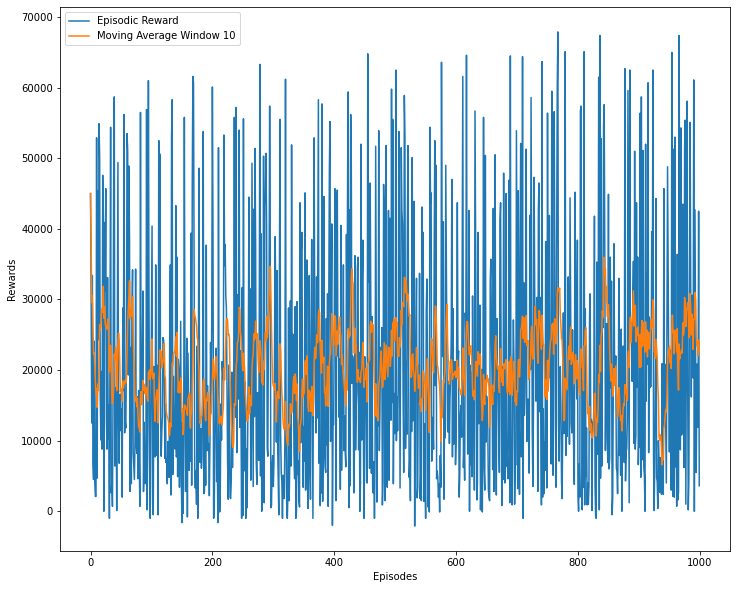

In [6]:
mach = Machine()
mach.curr_state = 0
machine1 = Machine_env(mach)
pol = policy_estimator(machine1)

#Parameters
episodes = 1000
gamma = 0.95
lr = 0.001
batchsize = 10

#writer = SummaryWriter(f"runs/gamma/lr_{lr}gamma_{gamma}episode_{episodes}batch_{batchsize}_mu0_{mu0}_no_entropy_reg")

results = reinforce(machine1,pol,episodes,batchsize,gamma,lr)

ave_rewards = results[0]
rewards = results[1]
episode = [i for i in range(len(ave_rewards))]
fig = plt.figure(figsize=(12,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,ave_rewards,label = f'Moving Average Window 10')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# Baseline Case

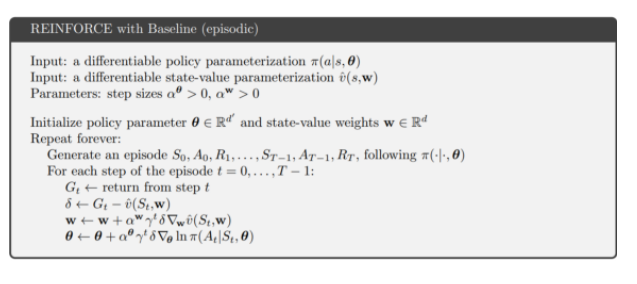

In [3]:
import torch.nn.functional as F
import gym
from machine import Machine
from GymMachEnv import MachineEnv

class policy_estimator(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        
        self.layer1 = nn.Linear(env.observation_space.shape[0],128)
        
        self.layer2 = nn.Linear(128,64)
        self.outlayer = nn.Linear(64,env.action_space.n)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
    
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.outlayer(x)

        return F.softmax(x,dim = -1)

class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 64)
        self.layer2 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #Nxt layer
        x = self.layer2(x)
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value
    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(state))
    return torch.stack(state_vals).squeeze()
    
    
def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    
    #store updates
    policy_loss = []
    
    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)
    
    #Backpropagation
    optimizer.zero_grad()
    (sum(policy_loss)/len(policy_loss)).backward()
    optimizer.step()
    
    return sum(policy_loss)
    

In [4]:
from torch.distributions import Categorical

def reinforce_baseline(machine,baseline_net,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_obs=[]
    batch_actions = []
    ave_reward_store = []
    batch_counter = 1
    batch_observation = []
    state_seq = []
    loss_arr = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.01)
    
    action_space = machine.action_space
    ep=0
    while ep < num_episodes:
        state = machine.reset()
        observation = []
        rewards = []
        actions = []
        
        
        while machine.done == False:
            observation.append(state)
            
            action_probs = policy_estimator(state) #convert to numpy and get action prob
            dist = Categorical(action_probs)
            action = dist.sample()
            state, reward, done, _ = machine.step(action)
            #print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            rewards.append(reward)
            actions.append(action)
            
            if machine.done == True:
                batch_rewards.extend(normalized_discount_reward(rewards, gamma))
                batch_obs.extend(observation)
                batch_actions.extend(actions)
                batch_counter+=1
                total_rewards.append(sum(rewards))
                
                if batch_counter == batch_size:
                    discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
                    #update policy
                    obs_tensor = torch.FloatTensor(batch_obs)
                    action_tensor = torch.LongTensor(batch_actions)
                    reward_tensor = torch.from_numpy(np.array(batch_rewards).copy()) #resolve stride problem
                    
                    #calculate state values 
                    state_value_tensor = stack_state_value(np.array(obs_tensor),baseline_net)

                    #train state value network
                    train_value(reward_tensor,state_value_tensor,state_val_optimizer)

                    #print(f"checking {reward_tensor}, {state_value_tensor}")
                    #calculate delta or advantage 
                    try:
                        deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
                        deltas = torch.tensor(deltas)
                    except:
                        print("Invalid episode")
                        continue


                    #update policy
                    logprob = torch.log(policy_estimator(obs_tensor))
                    selected_logprobs = logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = train_policy(deltas, selected_logprobs, optimizer)
                    loss_arr.append(loss)
                    
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_obs = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-10:])
                ave_reward_store.append(avg_rewards)
                # Print running average
                print("\rEp: {} Average of last {}: {:.2f}".format(ep+1,batch_size,avg_rewards), end="")
                ep+=1

        
    
    return (ave_reward_store,total_rewards,loss_arr)

In [8]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)
#print(machine1.reward_func)
baseline = StateValueNetwork(env.observation_space.shape[0])
pol = policy_estimator(env)

#Parameters
episodes = 10000
gamma = 0.99
lr= 0.01
batch_size=32

#writer = SummaryWriter(f"runs/baseline/gamma/lr_{lr}gamma_{gamma}episode_{episodes}_mu_{mu0}")
writer = None
results = reinforce_baseline(env,baseline,pol,episodes,batch_size,gamma,lr)
# rewards = results[0]
# actions = np.array(results[1])
# states = results[2]

# episode = [i for i in range(episodes)]

# #Moving average we will use a window size of 50

# moving_averages = []
# window_size = 10

# df = pd.DataFrame(rewards,columns = ['r'])
# moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

# fig = plt.figure(figsize=(10,10))
# plt.title(f'Average Reward vs Episodes: lr_{lr}, gamma_{gamma}')
# plt.plot(episode,rewards,label = 'Episodic Reward')
# plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
# plt.xlabel('Episodes')
# plt.ylabel('Rewards')
# plt.legend()
# plt.show()

Ep: 30 Average of last 32: 12730.00

<ipython-input-4-6a9dfd7becc0>:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  obs_tensor = torch.FloatTensor(batch_obs)


Ep: 10000 Average of last 32: 17100.00

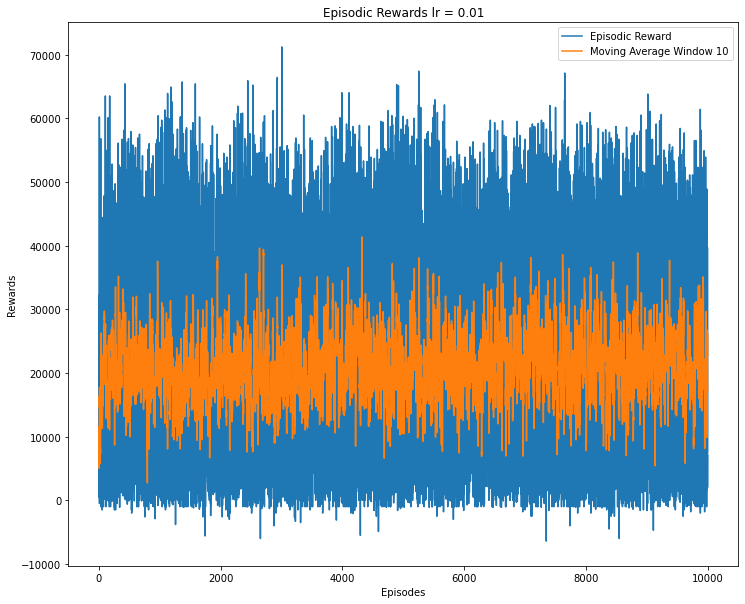

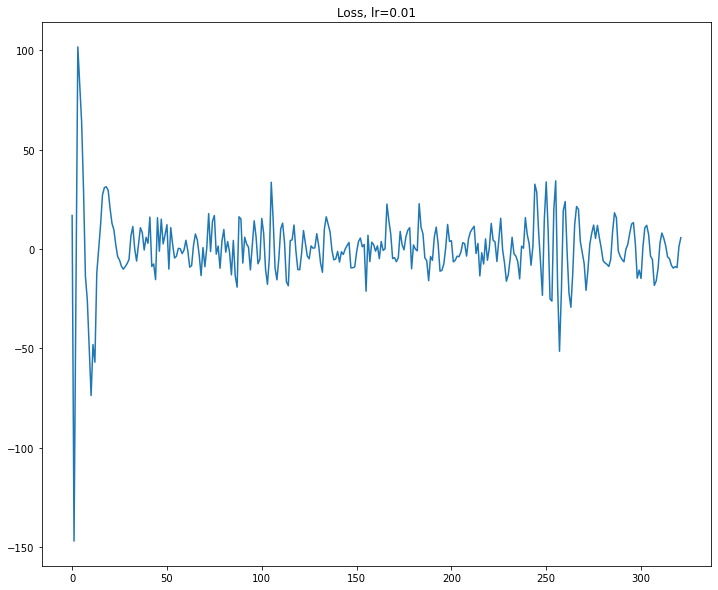

In [9]:
ave_rewards = results[0]
rewards = results[1]
episode = [i for i in range(len(ave_rewards))]
fig = plt.figure(figsize=(12,10))
plt.title('Episodic Rewards lr = 0.01')
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,ave_rewards,label = f'Moving Average Window 10')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()


loss_result = results[2]
fig = plt.figure(figsize=(12,10))
plt.title('Loss, lr=0.01')
plt.plot([i for i in range(len(loss_result))],loss_result)
plt.show()